# Overview

* From planet data over SF Bay
* 2800 80x80 RGB images labeled ship or no-ship
* 700 ships
* 2100 no ships


# Imports

In [ ]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import json  
import mpl_toolkits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks
from keras.utils.vis_utils import plot_model
%matplotlib inline

from sklearn.externals import joblib


from skimage.feature import hog
from skimage import data, color, exposure

# load images

In [22]:
os.listdir("shipsnet/shipsnet");

In [23]:
path =r'/Users/mayamidzik/metis/3-mcnulty/shipsnet/shipsnet'

In [24]:
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))

In [25]:
len(no_boats)

2100

# Subset boats and create image arrays

In [26]:
boats.extend(no_boats)

In [27]:
len(boats)

2800

In [28]:
image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/metis/3-mcnulty/shipsnet/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/metis/3-mcnulty/shipsnet/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

In [29]:
len(image_tag)

2800

In [30]:
d = {'image': image_data, 'tag': image_tag}
df = pd.DataFrame(data = d)

In [31]:
df.tail()

,image,tag
2795,"[[[71, 77, 59], [72, 78, 58], [74, 79, 60], [7...",0
2796,"[[[73, 79, 57], [76, 80, 60], [74, 77, 59], [7...",0
2797,"[[[54, 70, 52], [52, 68, 51], [46, 62, 47], [4...",0
2798,"[[[60, 73, 56], [60, 72, 56], [59, 71, 54], [5...",0
2799,"[[[56, 69, 57], [38, 51, 42], [44, 59, 47], [5...",0


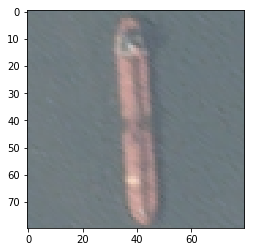

In [32]:
def plotOne(arr):
    """
    Plot one numpy array
    """
    plt.subplot(1,1,1)
    plt.imshow(arr)

plotOne(image_data[10])
    

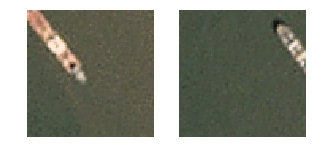

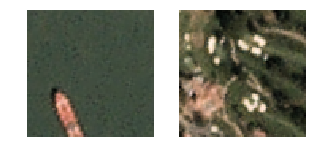

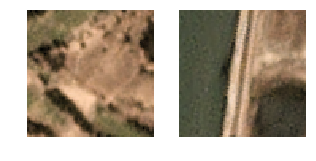

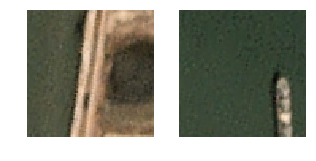

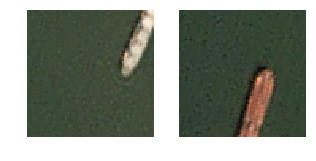

In [33]:
def plotTwo(data): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    i = 1
    for row in range(5):
        plt.figure(figsize=(5, 15))
        for col in range(2):
            plt.subplot(5,2,i)
            plt.imshow(data[i-1])
            plt.axis('off') 
            i+=1
    
plotTwo(image_data[-10:]) 

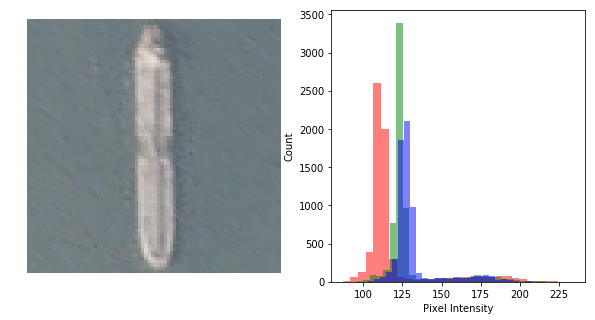

In [34]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

plotHistogram(image_data[9])

# Testing flip and rotate

In [35]:
test = image_data[4]

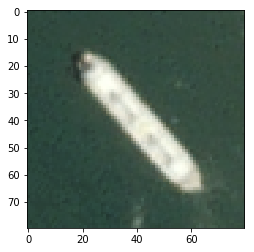

In [36]:
plotOne(test)

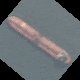

In [76]:
from PIL import Image

pil_im = Image.open(boats[10])
pil_im.resize((1000,1000))
pil_im.rotate(230)

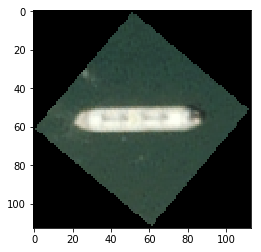

In [66]:
#rotate around the unit circle
from scipy import ndimage

rot = ndimage.interpolation.rotate(test,230, mode = 'constant')
plotOne(rot)

# Run HOG on images

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


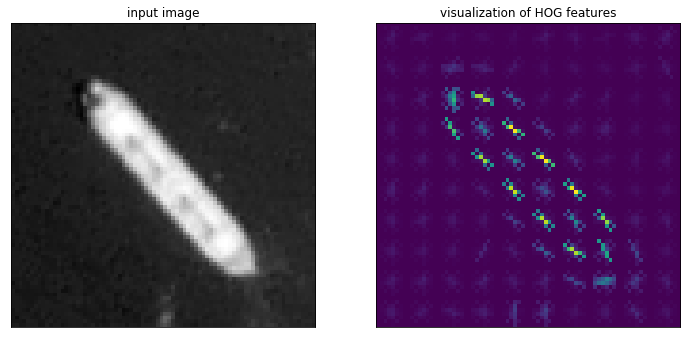

In [39]:
image = color.rgb2gray(test)
hog_vec, hog_vis = hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [40]:
len(hog_vis)

80

# Test out different models

## Run a KNN

In [57]:
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return vectors
    

In [ ]:
x_vect = make_vector(image_data)
y_vect = np.ravel(image_tag)

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x_vect,y_vect,test_size = 0.2 ,random_state = 123)

In [55]:
# Generate a confusion matrix plot: 
import pickle 
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
#     ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    pickle.dump(clf, open( "model.pkl", "wb" ) )
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.95
Test Data Accuracy:     0.93
[[375  29]
 [ 12 144]]


Precision:              0.97
Recall:                 0.93
Specificity:              0.92


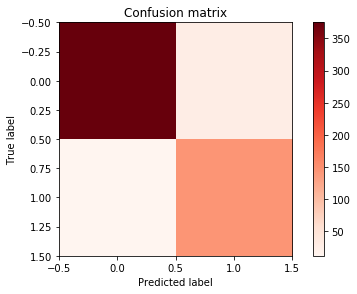

In [58]:
#Rewrite with global so I can access variables
Knn=  KNeighborsClassifier(n_neighbors=5)
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x_vect, y_vect, test_size=0.2, random_state=1234)
clf = Knn.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
# pickle.dump(clf, open( "model.pkl", "wb" ) )
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

#conf[0, 0] = TP
#conf[1, 0] = FP
#conf[0, 1] = FN
#conf[1, 1] = TN


print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.875000 (0.013243)
KNN: 0.912500 (0.020767)


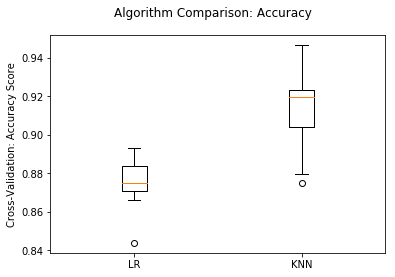

In [156]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier())) 
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
   
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)


# Practicing sliding windows

In [3]:
# import the necessary packages
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window
import argparse
import time
import cv2


In [4]:
image = cv2.imread('shipsnet/scenes/lb_1.jpg')

In [5]:
plotOne(image)

NameError: name 'plotOne' is not defined

In [1]:
(winW, winH) = (80, 80)

for resized in pyramid(image, scale=1.5):
    cv.imshow(resized)
#     for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
#         if window.shape[0] != winH or window.shape[1] != winW:
#             continue
#         clone = resized.copy()
#         cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
#         cv2.imshow("Window", clone)
#         cv2.waitKey(1)
#         time.sleep(0.025)
        
        


NameError: name 'pyramid' is not defined